# DeepDreaming with TensorFlow

>[Loading the model graph](#loading)

>[Naive feature visualization](#naive)

>[Multiscale image generation](#multiscale)

>[Laplacian Pyramid Gradient Normalization](#laplacian)

>[Playing with feature visualzations](#playing)

>[DeepDream](#deepdream)



This notebook demonstrates a number of Convolutional Neural Network image generation techniques implemented with TensorFlow for fun and science:

- visualize individual feature channels and their combinations to explore the space of patterns learned by the neural network (see [GoogLeNet](http://storage.googleapis.com/deepdream/visualz/tensorflow_inception/index.html) and [VGG16](http://storage.googleapis.com/deepdream/visualz/vgg16/index.html) galleries)
- embed TensorBoard graph visualizations into Jupyter notebooks
- produce high-resolution images with tiled computation ([example](http://storage.googleapis.com/deepdream/pilatus_flowers.jpg))
- use Laplacian Pyramid Gradient Normalization to produce smooth and colorful visuals at low cost
- generate DeepDream-like images with TensorFlow (DogSlugs included)


The network under examination is the [GoogLeNet architecture](https://arxiv.org/pdf/1409.4842.pdf), trained to classify images into one of 1000 categories of the [ImageNet](http://image-net.org/) dataset. It consists of a set of layers that apply a sequence of transformations to the input image. The parameters of these transformations were determined during the training process by a variant of gradient descent algorithm. The internal image representations may seem obscure, but it is possible to visualize and interpret them. In this notebook we are going to present a few tricks that allow to make these visualizations both efficient to generate and even beautiful. Impatient readers can start with exploring the full galleries of images generated by the method described here for [GoogLeNet](http://storage.googleapis.com/deepdream/visualz/tensorflow_inception/index.html) and [VGG16](http://storage.googleapis.com/deepdream/visualz/vgg16/index.html) architectures.

In [1]:
# boilerplate code
from __future__ import print_function
import os
import imageio as io
# maybe choose between imageio and BytesIO?
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import matplotlib.pyplot as plt
from skimage.transform import resize as imresize

import tensorflow as tf

/Users/jonathansherman/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<a id='loading'></a>
## Loading the model graph

The pretrained network can be downloaded [here](https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip). Unpack the `tensorflow_inception_graph.pb` file from the archive and set its path to `model_fn` variable. Alternatively you can uncomment and run the following cell to download the network:

In [2]:
#!wget https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip inception5h.zip

In [3]:
#sess.close()
model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model from the model_fn file 
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

In [4]:

# Helper functions for TF Graph visualization

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
# internal structure. We are going to visualize "Conv2D" nodes.
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

To take a glimpse into the kinds of patterns that the network learned to recognize, we will try to generate images that maximize the sum of activations of particular channel of a particular convolutional layer of the neural network. The network we explore contains many convolutional layers, each of which outputs tens to hundreds of feature channels, so we have plenty of patterns to explore.

In [5]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))


Number of layers 59
Total number of feature channels: 7548


In [6]:
def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

In [7]:
# TO-DO : fix index calling so import is not twice printed with T(layer)

layer=layers[0]
print(layer)
layer = layer.split("/")[1]
print(layer)

import/conv2d0_pre_relu/conv
conv2d0_pre_relu


In [8]:
T(layer)

<tf.Tensor 'import/conv2d0_pre_relu:0' shape=(?, ?, ?, 64) dtype=float32>

In [9]:
for l, layer in enumerate(layers):
    layer = layer.split("/")[1]
    num_channels = T(layer).shape[3]
    print(l, layer, num_channels)

0 conv2d0_pre_relu 64
1 conv2d1_pre_relu 64
2 conv2d2_pre_relu 192
3 mixed3a_pool_reduce_pre_relu 32
4 mixed3a_5x5_bottleneck_pre_relu 16
5 mixed3a_5x5_pre_relu 32
6 mixed3a_3x3_bottleneck_pre_relu 96
7 mixed3a_3x3_pre_relu 128
8 mixed3a_1x1_pre_relu 64
9 mixed3b_pool_reduce_pre_relu 64
10 mixed3b_5x5_bottleneck_pre_relu 32
11 mixed3b_5x5_pre_relu 96
12 mixed3b_3x3_bottleneck_pre_relu 128
13 mixed3b_3x3_pre_relu 192
14 mixed3b_1x1_pre_relu 128
15 mixed4a_pool_reduce_pre_relu 64
16 mixed4a_5x5_bottleneck_pre_relu 16
17 mixed4a_5x5_pre_relu 48
18 mixed4a_3x3_bottleneck_pre_relu 96
19 mixed4a_3x3_pre_relu 204
20 mixed4a_1x1_pre_relu 192
21 head0_bottleneck_pre_relu 128
22 mixed4b_pool_reduce_pre_relu 64
23 mixed4b_5x5_bottleneck_pre_relu 24
24 mixed4b_5x5_pre_relu 64
25 mixed4b_3x3_bottleneck_pre_relu 112
26 mixed4b_3x3_pre_relu 224
27 mixed4b_1x1_pre_relu 160
28 mixed4c_pool_reduce_pre_relu 64
29 mixed4c_5x5_bottleneck_pre_relu 24
30 mixed4c_5x5_pre_relu 64
31 mixed4c_3x3_bottleneck_pre_

<a id='naive'></a>
## Naive feature visualization

Let's start with a naive way of visualizing these. Image-space gradient ascent!

In [10]:
# Picking some internal layer. Note that we use outputs before applying the ReLU nonlinearity
# to have non-zero gradients for features with negative initial activations.
layer = 'mixed4d_3x3_bottleneck_pre_relu'
print(layers[37])
channel = 139 # picking some feature channel to visualize

# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0


import/mixed4d_3x3_bottleneck_pre_relu/conv


In [11]:

def showarray(a, fmt='jpeg'):
    '''create a jpeg file from an array a and visualize it'''
    # clip the values to be between 0 and 255
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5


<a id="multiscale"></a>
## Multiscale image generation

Looks like the network wants to show us something interesting! Let's help it. We are going to apply gradient ascent on multiple scales. Details formed on smaller scale will be upscaled and augmented with additional details on the next scale.

With multiscale image generation it may be tempting to set the number of octaves to some high value to produce wallpaper-sized images. Storing network activations and backprop values will quickly run out of GPU memory in this case. There is a simple trick to avoid this: split the image into smaller tiles and compute each tile gradient independently. Applying random shifts to the image before every iteration helps avoid tile seams and improves the overall image quality.

In [44]:
def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

# Helper function that uses TF to resize an image
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)


def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2] # size of the image
    # Probably causing the jitter - TRY having each iteration end on same position
    sx, sy = np.random.randint(sz, size=2) # random shift numbers generated
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0) #shift the whole image. np.roll = Roll array elements along a given axis
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz] # get the image patch (tile)
            g = sess.run(t_grad, {t_input:sub}) # calculate the gradient only in the image patch not in the whole image!
            grad[y:y+sz,x:x+sz] = g # put the whole gradient together from the tiled gradients g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0) # shift back

<a id="laplacian"></a>
## Laplacian Pyramid Gradient Normalization

This looks better, but the resulting images mostly contain high frequencies. Can we improve it? One way is to add a smoothness prior into the optimization objective. This will effectively blur the image a little every iteration, suppressing the higher frequencies, so that the lower frequencies can catch up. This will require more iterations to produce a nice image. Why don't we just boost lower frequencies of the gradient instead? One way to achieve this is through the [Laplacian pyramid](https://en.wikipedia.org/wiki/Pyramid_%28image_processing%29#Laplacian_pyramid) decomposition. We call the resulting technique _Laplacian Pyramid Gradient Normalization_.

In [13]:
k = np.float32([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)

def lap_split(img):
    '''Split the image into lo and hi frequency components'''
    with tf.name_scope('split'):
        lo = tf.nn.conv2d(img, k5x5, [1,2,2,1], 'SAME')
        lo2 = tf.nn.conv2d_transpose(lo, k5x5*4, tf.shape(img), [1,2,2,1])
        hi = img-lo2
    return lo, hi

def lap_split_n(img, n):
    '''Build Laplacian pyramid with n splits'''
    levels = []
    for i in range(n):
        img, hi = lap_split(img)
        levels.append(hi)
    levels.append(img)
    return levels[::-1]

def lap_merge(levels):
    '''Merge Laplacian pyramid'''
    img = levels[0]
    for hi in levels[1:]:
        with tf.name_scope('merge'):
            img = tf.nn.conv2d_transpose(img, k5x5*4, tf.shape(hi), [1,2,2,1]) + hi
    return img

def normalize_std(img, eps=1e-10):
    '''Normalize image by making its standard deviation = 1.0'''
    with tf.name_scope('normalize'):
        std = tf.sqrt(tf.reduce_mean(tf.square(img)))
        return img/tf.maximum(std, eps)

def lap_normalize(img, scale_n=4):
    '''Perform the Laplacian pyramid normalization.'''
    img = tf.expand_dims(img,0)
    tlevels = lap_split_n(img, scale_n)
    tlevels = list(map(normalize_std, tlevels))
    out = lap_merge(tlevels)
    return out[0,:,:,:]

# Showing the lap_normalize graph with TensorBoard
lap_graph = tf.Graph()
with lap_graph.as_default():
    lap_in = tf.placeholder(np.float32, name='lap_in')
    lap_out = lap_normalize(lap_in)
show_graph(lap_graph)

In [41]:
#image preprocessing
def preprocess(img, crop=True, changesize=True, dsize=(224, 224)):
    """Summary

    Parameters
    ----------
    img : TYPE
        Description
    crop : bool, optional
        Description
    resize : bool, optional
        Description
    dsize : tuple, optional
        Description

    Returns
    -------
    TYPE
        Description
    """
    if img.dtype == np.uint8:
        img = img / 255.0

    if crop:
        short_edge = min(img.shape[:2])
        yy = int((img.shape[0] - short_edge) / 2)
        xx = int((img.shape[1] - short_edge) / 2)
        crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
    else:
        crop_img = img

    if changesize:
        norm_img = imresize(crop_img, dsize, preserve_range=True)
    else:
        norm_img = crop_img

    return (norm_img).astype(np.float32)


# Note: entered additional t_score for summative gradient between 2 points. 
def render_lapnorm2(t_obj, t_obj2=tf.zeros([0]), img0=img_noise, score='mean', vis='clear', visfunc=visstd,
                   iter_n=10, step=1.0, octave_n=3, octave_scale=1.4, lap_n=4, file_dir=os.getcwd()):
    if score == 'mean':
        t_score = tf.reduce_mean(t_obj) # defining the optimization objective
        t_score2 = tf.reduce_mean(t_obj2) # defining the optimization objective
    if score == 'sum':
        t_score = tf.reduce_sum(t_obj) # defining the optimization objective
        t_score2 = tf.reduce_sum(t_obj2) # defining the optimization objective
    t_grad = tf.gradients(t_score+t_score2, t_input)[0] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))

    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            g = lap_norm_func(g)
            img += g*step
            print('.', end = ' ')
        if vis == 'clear':
            clear_output()
            showarray(visfunc(img))
        if vis == 'all':
            showarray(visfunc(img))
        if vis == 'zoomin':
                crop = 1
                img_c = img
                # just for more color
                img_c += img*1.02
                img_c = img_c[crop:-crop, crop:-crop]
                print(img_c.shape)
                img_c = imresize(img_c, (len(img[0]), len(img[1]), 3), order=4,
                     clip=False, preserve_range=True)#[np.newaxis].astype(np.float32)
                img = img_c
                print(img.shape)
    if vis == 'fin':
        showarray(visfunc(img))
    if vis == 'save':
        img = visfunc(img)
        img = np.uint8(np.clip(img, 0, 1)*255)
        io.imwrite(file_dir+'/interp%.3f.png' % (wght1), img)
    if vis == 'zoomin':
        img_c = visfunc(img_c)
        img_c = np.uint8(np.clip(img_c,0, 1)*255)
        io.imwrite(file_dir+'/zinterp%.3f.png' % (wght1), img_c)
        
# TO-DO: incorporate the mean score func internall below. Add flag for "sum_score" function as well (incorporate too)
def render_lapnorm2_w(t_obj, t_obj2=tf.zeros([0]), img0=img_noise, score='mean', op='add', wght1=0.5, wght2=0.5, vis='clear', visfunc=visstd,
                   iter_n=10, step=1.0, octave_n=3, octave_scale=1.4, lap_n=4, file_dir=os.getcwd()):
    if score == 'mean':
        t_score = tf.reduce_mean(t_obj) # defining the optimization objective
        t_score2 = tf.reduce_mean(t_obj2) # defining the optimization objective
    if score == 'sum':
        t_score = tf.reduce_sum(t_obj) # defining the optimization objective
        t_score2 = tf.reduce_sum(t_obj2) # defining the optimization objective
    if op=='add':
        t_grad = tf.gradients(wght1*t_score+wght2*t_score2, t_input)[0] # behold the power of automatic differentiation!
    if op=='subtract':
        t_grad = tf.gradients(wght1*t_score-wght2*t_score2, t_input)[0] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))
    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            g = lap_norm_func(g)
            img += g*step
            print('.', end = ' ')
        if vis == 'clear':
            clear_output()
            showarray(visfunc(img))
        if vis == 'all':
            showarray(visfunc(img))
        if vis == 'zoomin':
            crop = 25
            img_c = img
            # just for more color
            img_c += img*0.2
            img_c = img_c[crop:-crop, crop:-crop]
            print(img_c.shape)
            img_c = imresize(img_c, (len(img[0]), len(img[1]), 3), order=4,
                 clip=False, preserve_range=True)#[np.newaxis].astype(np.float32)
            img = img_c
            print(img.shape)
    if vis == 'fin':
        showarray(visfunc(img))
    if vis == 'save':
        img = visfunc(img)
        img = np.uint8(np.clip(img, 0, 1)*255)
        io.imwrite(file_dir+'/interp%.3f.png' % (wght1), img)
    if vis == 'zoomin':
        img_c = visfunc(img_c)
        img_c = np.uint8(np.clip(img_c,0, 1)*255)
        io.imwrite(file_dir+'/zinterp%.3f.png' % (wght1), img_c)


. . . . . . . . . . 

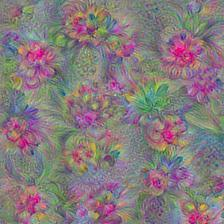

. . . . . . . . . . 

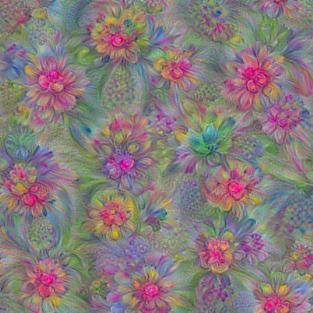

. . . . . . . . . . 

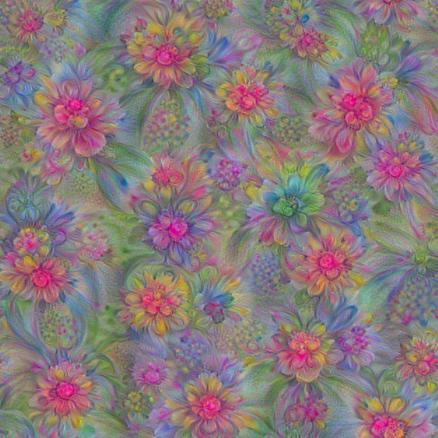

In [15]:
render_lapnorm2(T(layer)[:,:,:,channel], vis='all')

<a id="playing"></a>
## Playing with feature visualizations

We got a nice smooth image using only 10 iterations per octave. In case of running on GPU this takes just a few seconds. Let's try to visualize another channel from the same layer. The network can generate wide diversity of patterns.

In [16]:
print(layer)
print(channel)

mixed4d_3x3_bottleneck_pre_relu
139


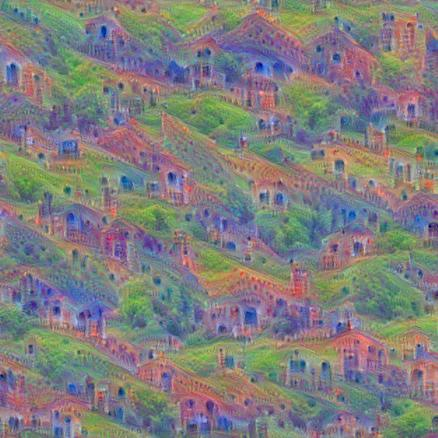

In [23]:
render_lapnorm2(T(layer)[:,:,:,65])


Lower layers produce features of lower complexity.

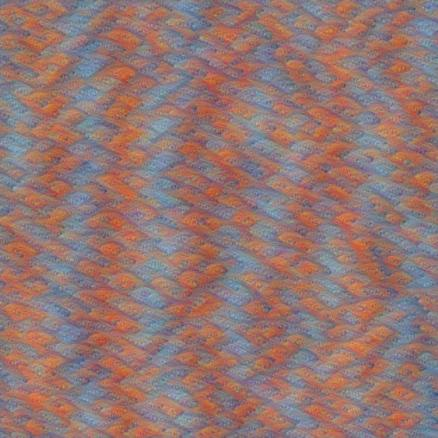

In [18]:
render_lapnorm2(T('mixed3b_1x1_pre_relu')[:,:,:,121])

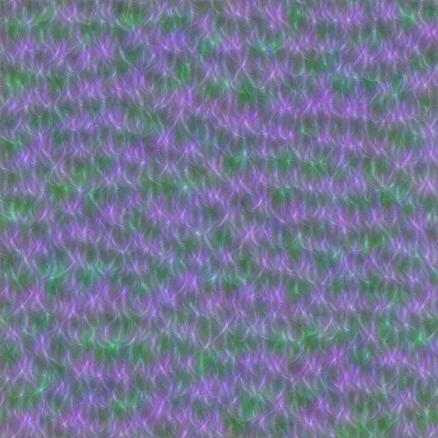

In [46]:
render_lapnorm2(-T('mixed3b_1x1_pre_relu')[:,:,:,121])

There are many interesting things one may try. For example, optimizing a linear combination of features often gives a "mixture" pattern.

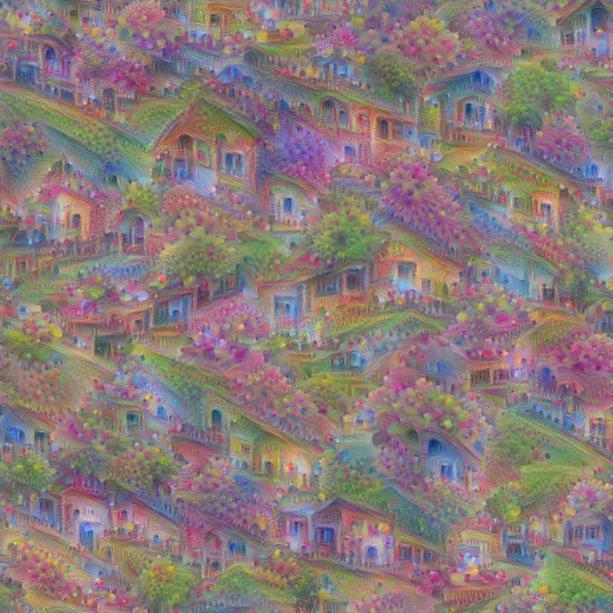

In [20]:
render_lapnorm2(T(layer)[:,:,:,65]+T(layer)[:,:,:,139], octave_n=4)

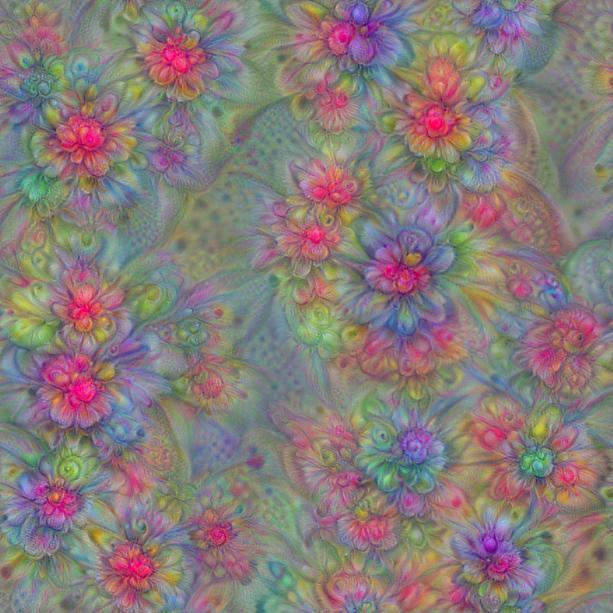

In [21]:
img0 = PIL.Image.open('116.jpg')
img0 = np.float32(img0)

render_lapnorm2(T(layer)[:,:,:,65]/T(layer)[:,:,:,139]-T(layer)[:,:,:,65]*T(layer)[:,:,:,139], octave_n=4)

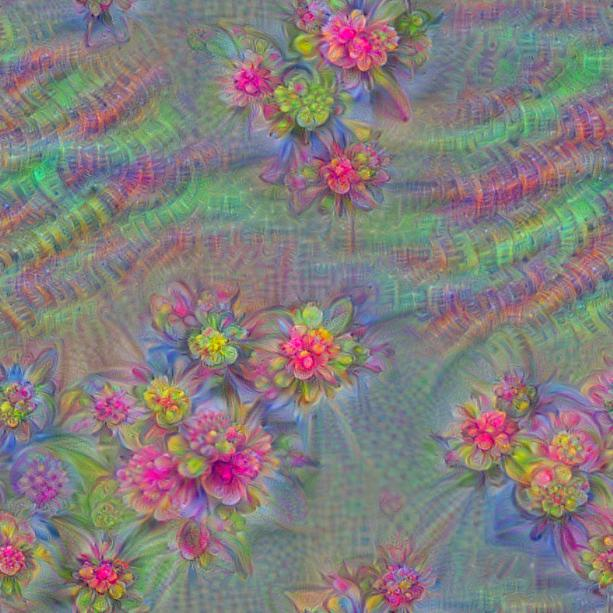

In [22]:
render_lapnorm2(-T(layer)[:,:,:,65]**2 + T(layer)[:,:,:,139]**2, octave_n=4)

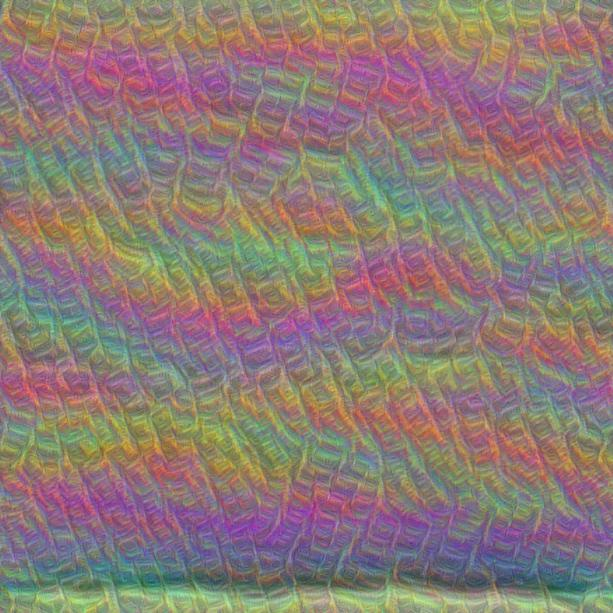

In [23]:
render_lapnorm2(T('mixed3b_3x3_pre_relu')[:,:,:,41], octave_n=4)

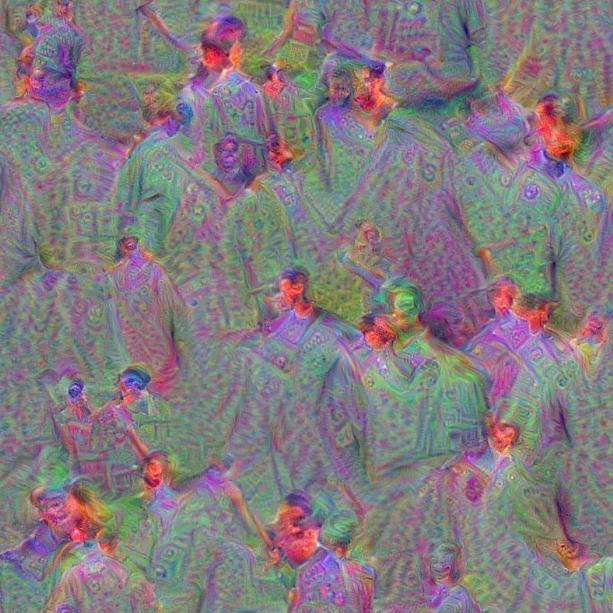

In [24]:
render_lapnorm2(T('mixed4e_5x5_pre_relu')[:,:,:,50], octave_n=4)

We can even combine features from different layers by obtaining just the score of one and passing it to the other to jointly calculate the gradient

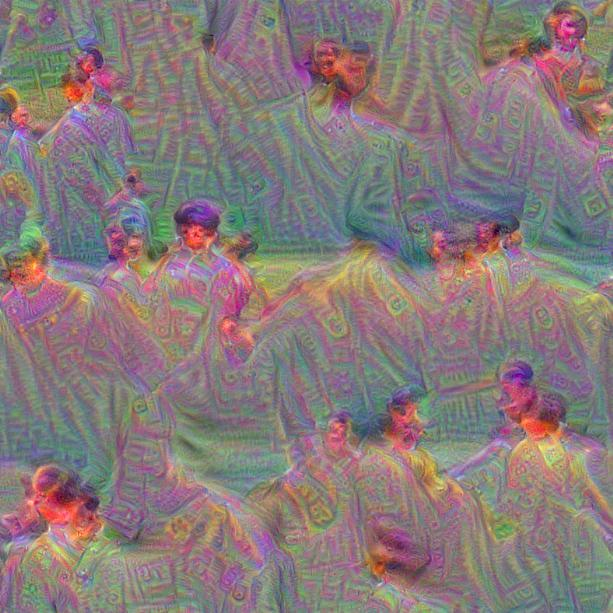

In [17]:
feat_layer2 = T('mixed3b_3x3_pre_relu')[:,:,:,41]

render_lapnorm2(T('mixed4e_5x5_pre_relu')[:,:,:,50], t_obj2=feat_layer2, octave_n=4)

With sum instead of mean scores

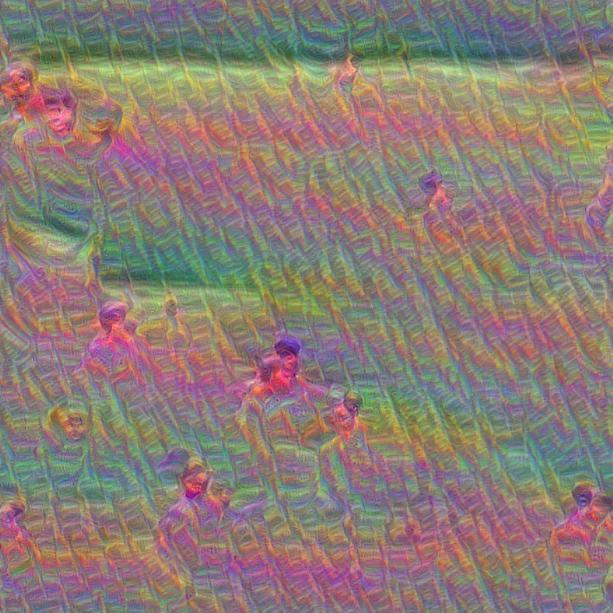

In [50]:
render_lapnorm2(T('mixed4e_5x5_pre_relu')[:,:,:,50], t_obj2=feat_layer2, score='sum', octave_n=4)

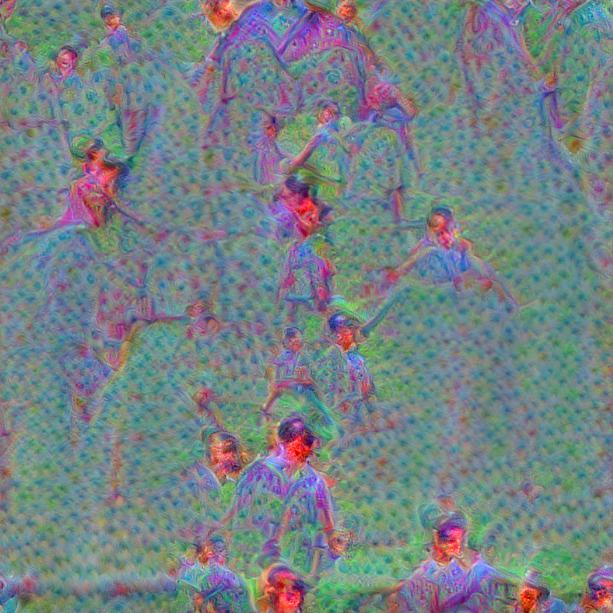

In [52]:
render_lapnorm2(T('mixed4e_5x5_pre_relu')[:,:,:,50], t_obj2=-feat_layer2, octave_n=4)

'sum' score seems to favor the lower level texture in this case

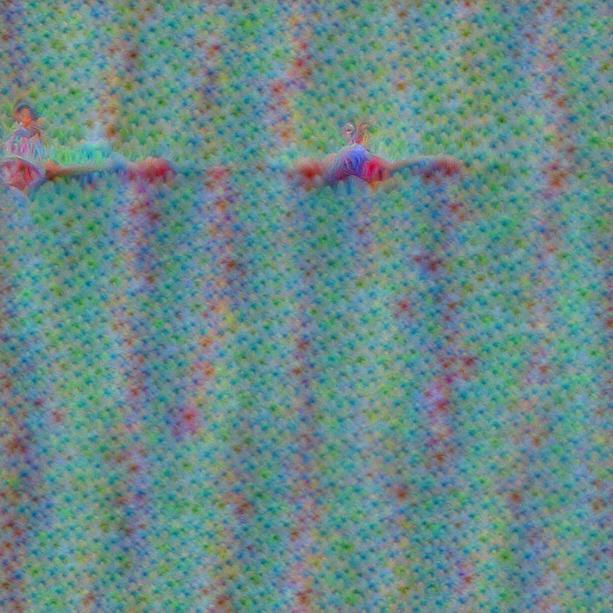

In [53]:
render_lapnorm2(T('mixed4e_5x5_pre_relu')[:,:,:,50], t_obj2=-feat_layer2, score='sum', octave_n=4)

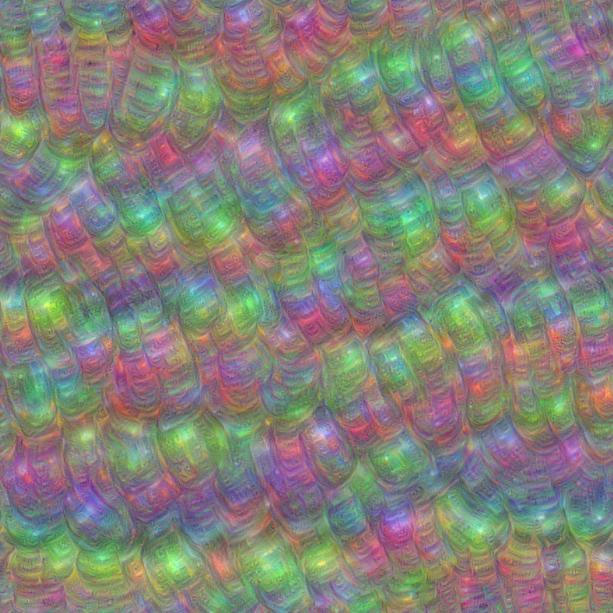

In [56]:
render_lapnorm2(-T('mixed4e_5x5_pre_relu')[:,:,:,50], t_obj2=feat_layer2, octave_n=4)

Double negative features with 'sum' shows interesting results

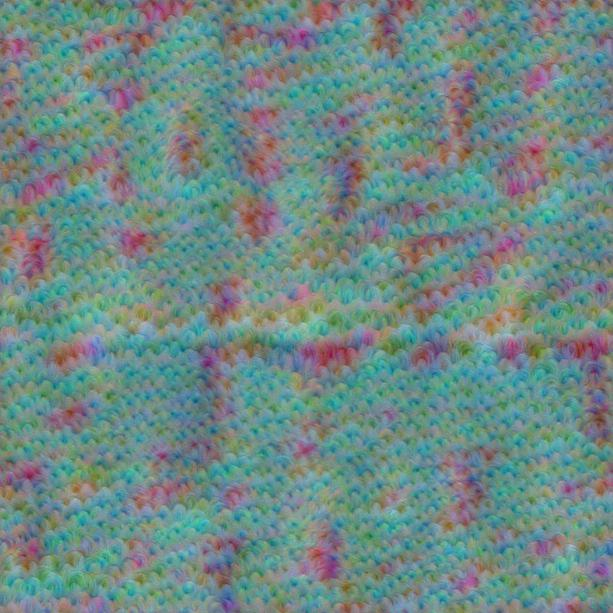

In [59]:
render_lapnorm2(-T('mixed4e_5x5_pre_relu')[:,:,:,50], t_obj2=-feat_layer2, score='sum', octave_n=4)

Experiment with different optimizations (reduce_max/sum/etc) and weighting the scores

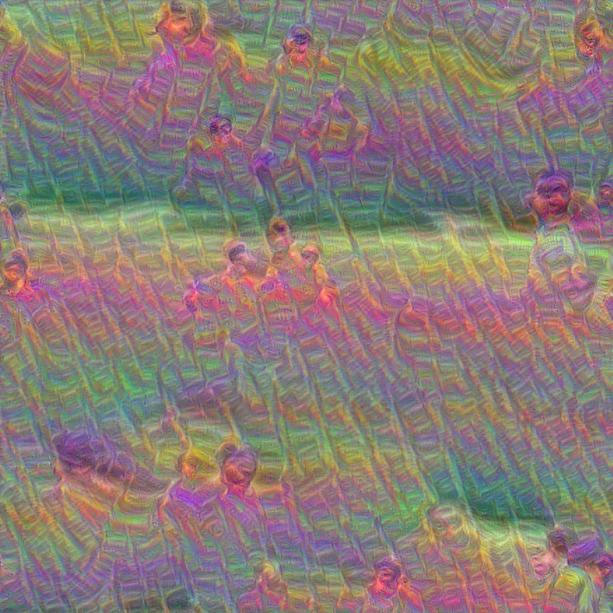

In [61]:
render_lapnorm2_w(T('mixed4e_5x5_pre_relu')[:,:,:,50], t_obj2=feat_layer2, wght1=0.2, wght2=0.8, octave_n=4)

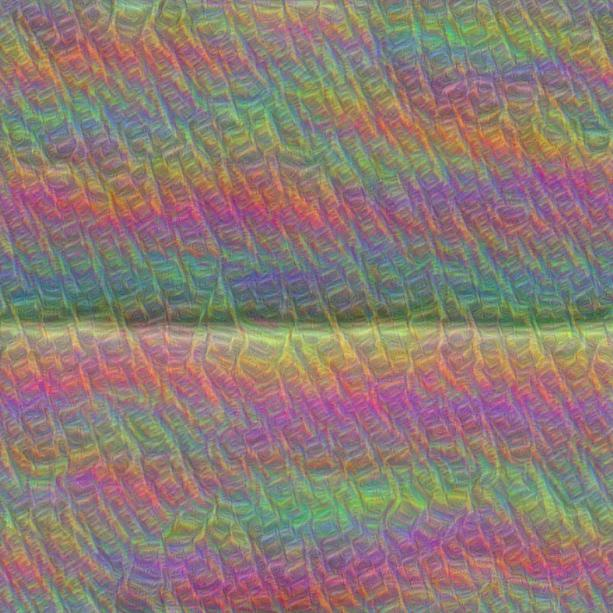

In [62]:
render_lapnorm2_w(T('mixed4e_5x5_pre_relu')[:,:,:,50], t_obj2=feat_layer2, score='sum', wght1=0.2, wght2=0.8, octave_n=4)

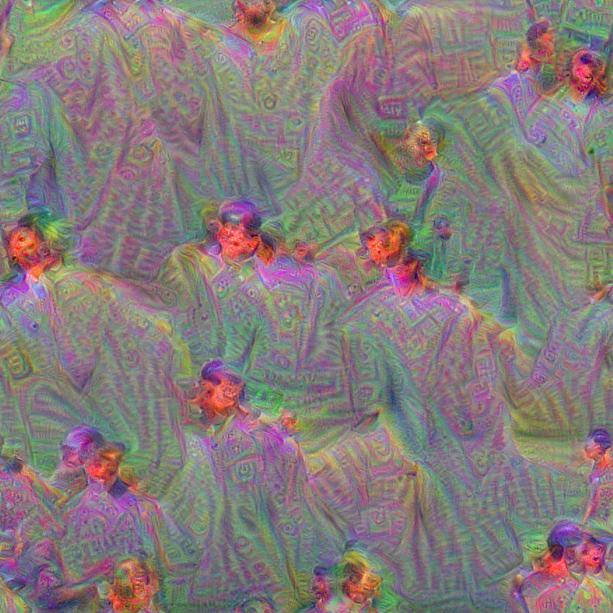

In [66]:
render_lapnorm2_w(T('mixed4e_5x5_pre_relu')[:,:,:,50], t_obj2=feat_layer2, wght1=0.6, wght2=0.4, octave_n=4)

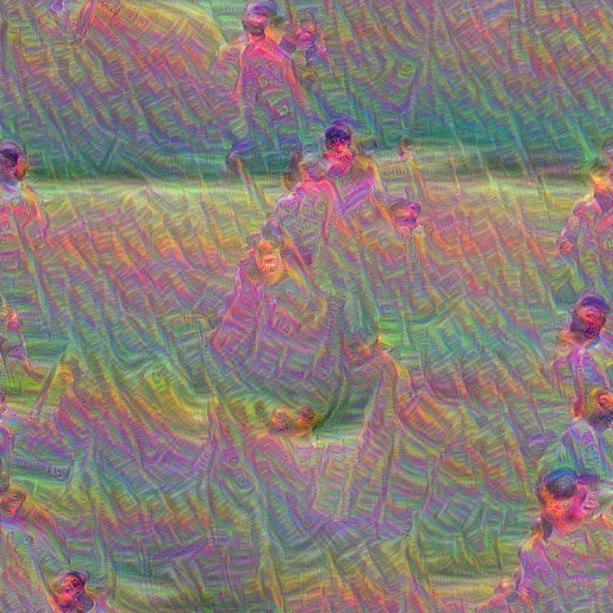

In [67]:
render_lapnorm2_w(T('mixed4e_5x5_pre_relu')[:,:,:,50], t_obj2=feat_layer2, score='sum', wght1=0.6, wght2=0.4, octave_n=4)

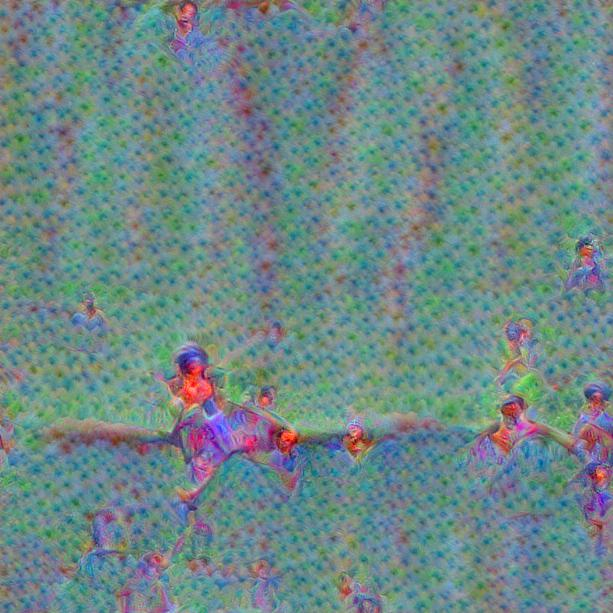

In [69]:
render_lapnorm2_w(T('mixed4e_5x5_pre_relu')[:,:,:,50], t_obj2=feat_layer2, op='subtract', wght1=0.4, wght2=0.6, octave_n=4)

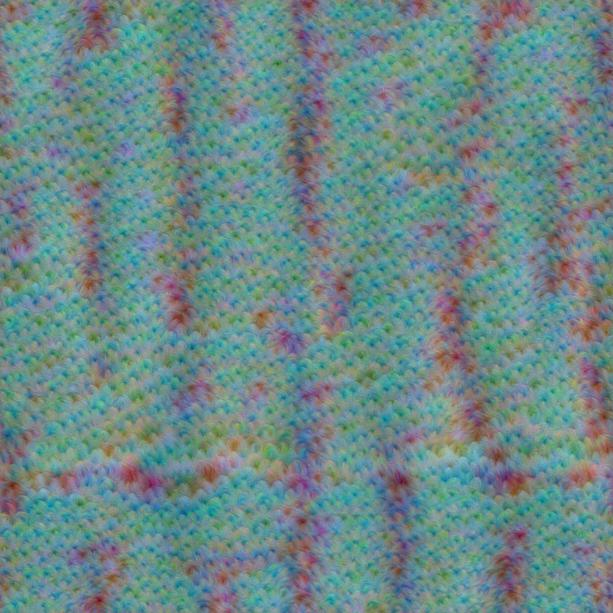

In [73]:
render_lapnorm2_w(-T('mixed4e_5x5_pre_relu')[:,:,:,50], t_obj2=feat_layer2, score='sum', op='subtract', wght1=0.4, wght2=0.6, octave_n=4)

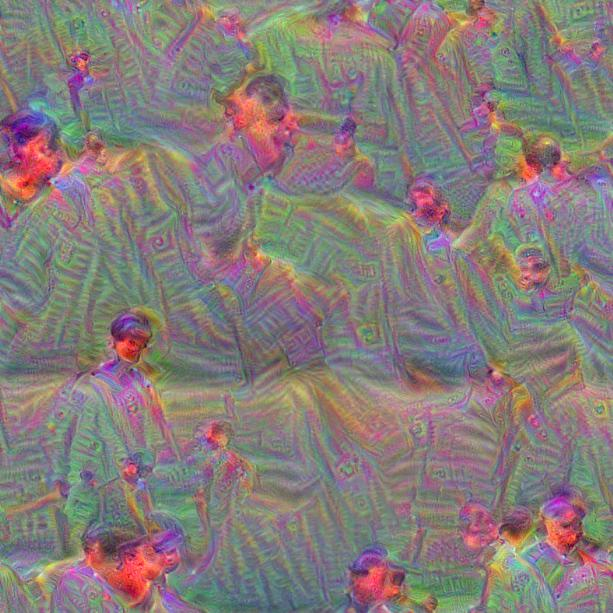

In [119]:
# control each result with stable noise (or not) with seed
np.random.seed(1)
norm_noise = np.random.normal(loc =0.0, scale =0.25, size=(224,224,3))
render_lapnorm2_w(T('mixed4e_5x5_pre_relu')[:,:,:,50], t_obj2=feat_layer2, img0=norm_noise, op='add', wght1=0.5, wght2=0.5, octave_n=4)

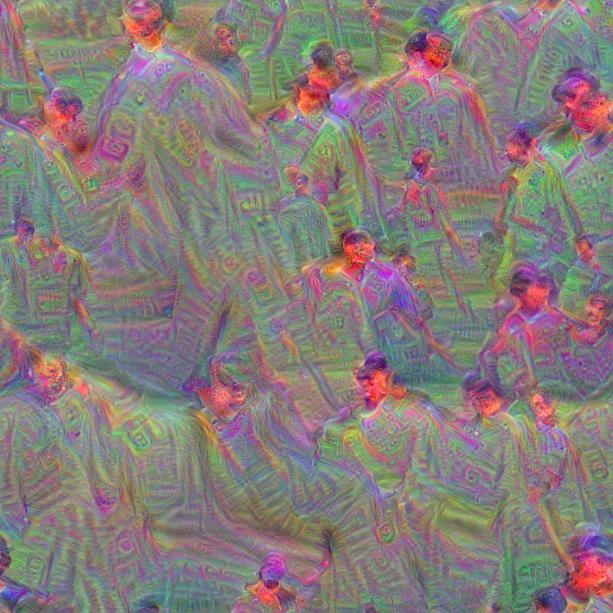

In [120]:
# control stable noise (or not) with seed
np.random.seed(0)
norm_noise = np.random.normal(loc =0.0, scale =0.25, size=(224,224,3))
render_lapnorm2_w(T('mixed4e_5x5_pre_relu')[:,:,:,50], t_obj2=feat_layer2, img0=norm_noise, op='add', wght1=0.5, wght2=0.5, octave_n=4)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

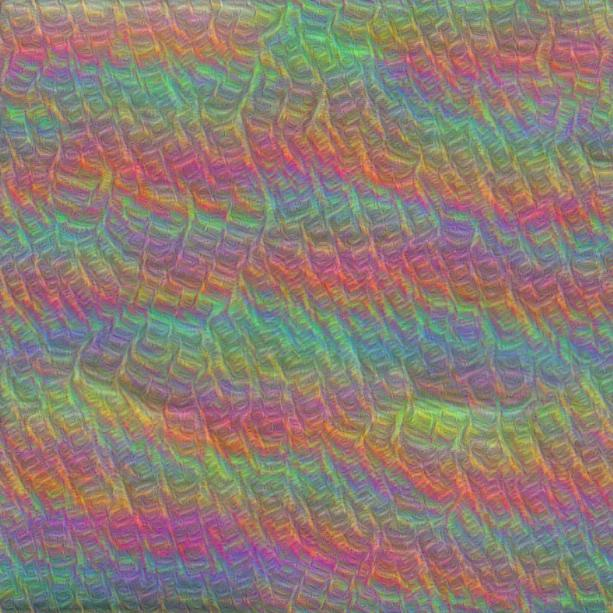

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

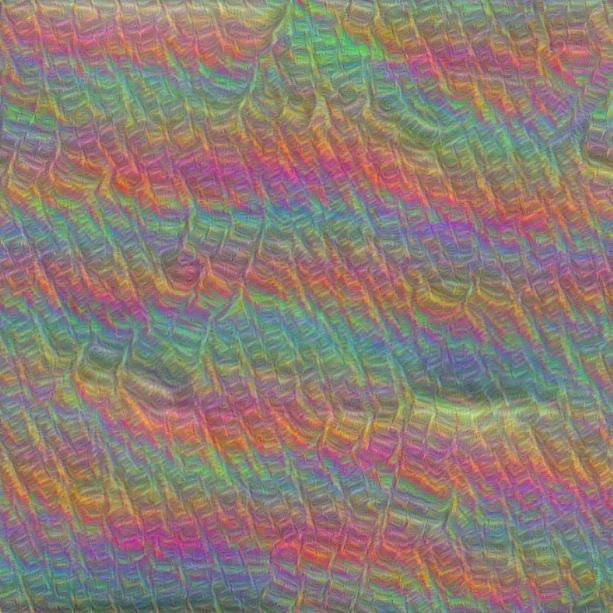

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

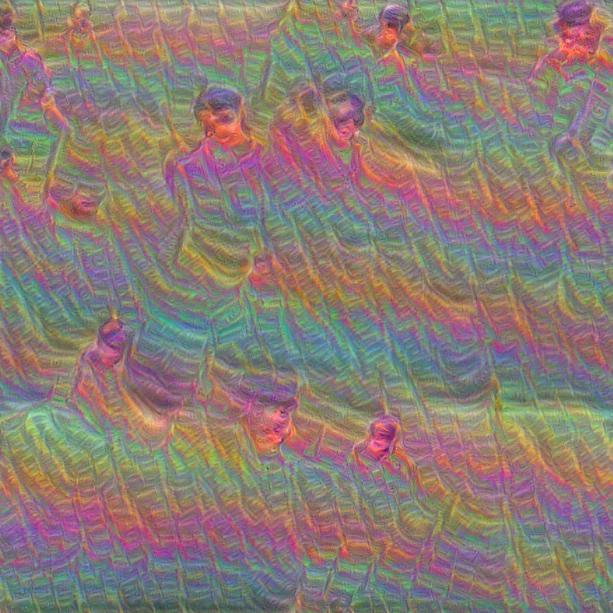

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

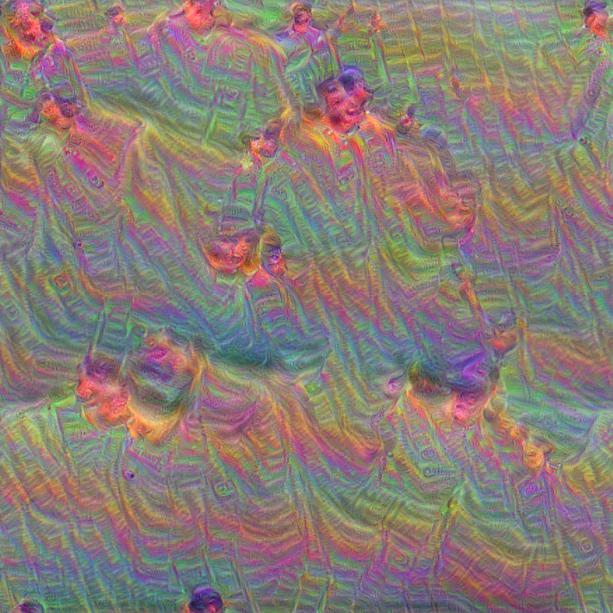

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

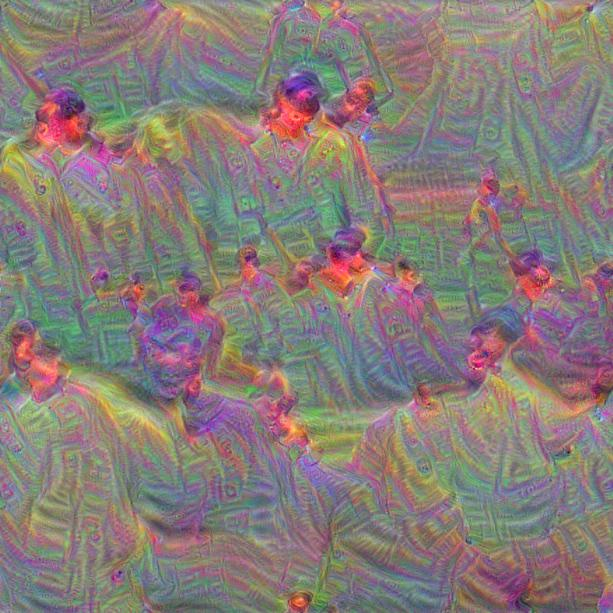

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

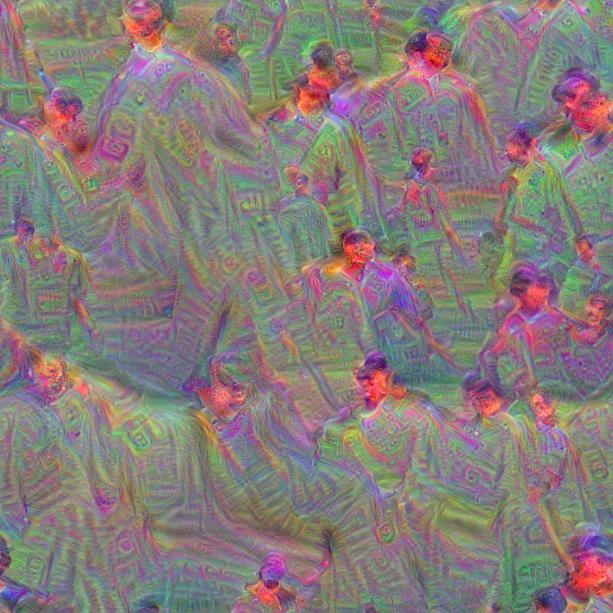

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

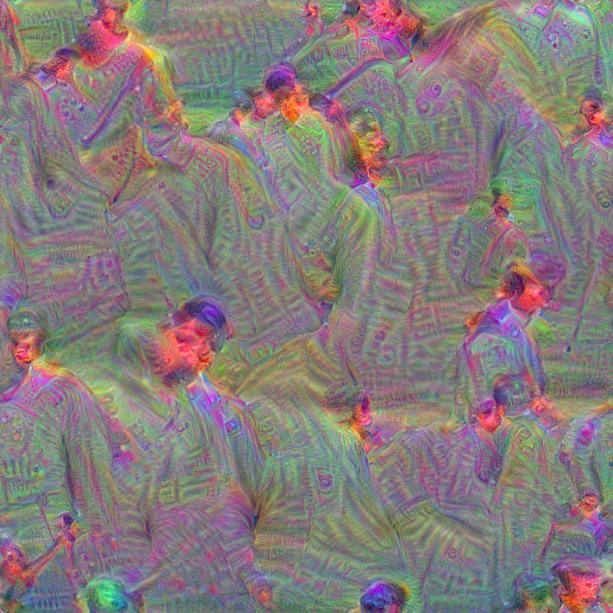

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

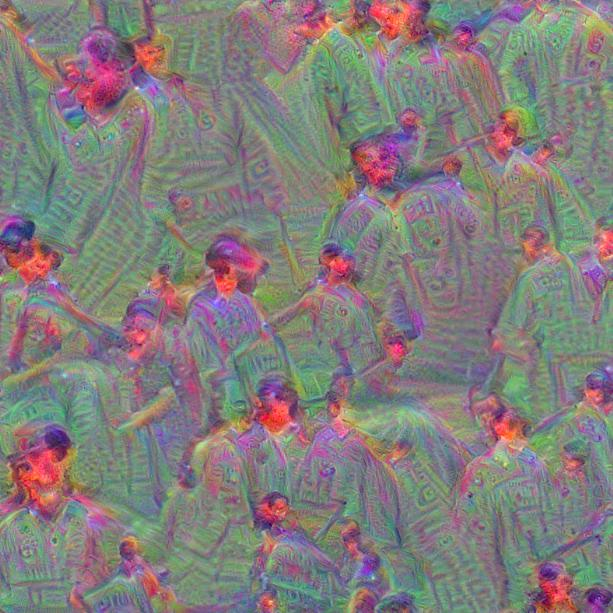

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

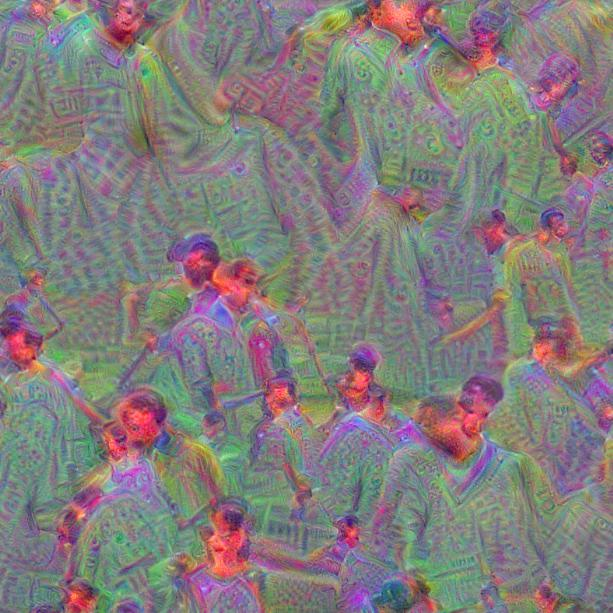

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

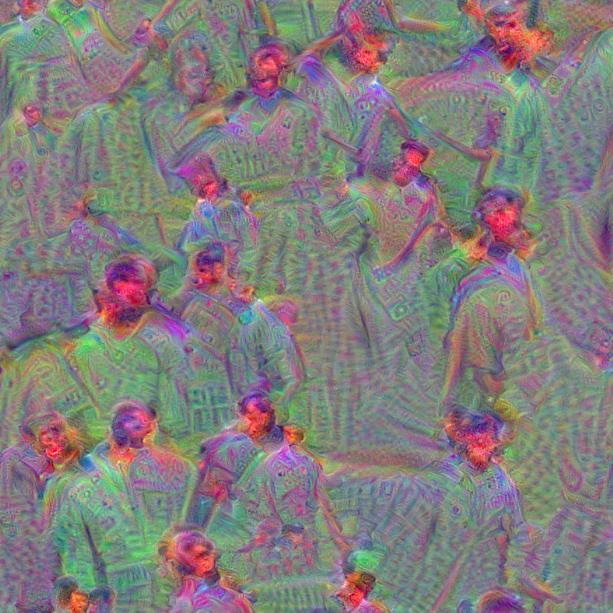

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

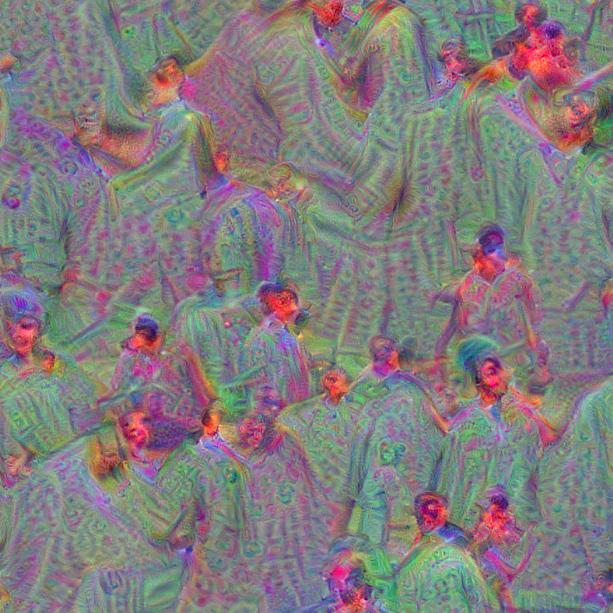

In [122]:
frames = 10
for i in range(frames+1):
    # control stable noise (or not) with seed
    np.random.seed(0)
    norm_noise = np.random.normal(loc =0.0, scale =0.25, size=(224,224,3))
    wght1 = i/frames
    wght2 = (frames-i)/frames
    render_lapnorm2_w(T('mixed4e_5x5_pre_relu')[:,:,:,50], t_obj2=feat_layer2, img0=norm_noise, op='add', vis='fin', wght1=wght1, wght2=wght2, octave_n=4)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

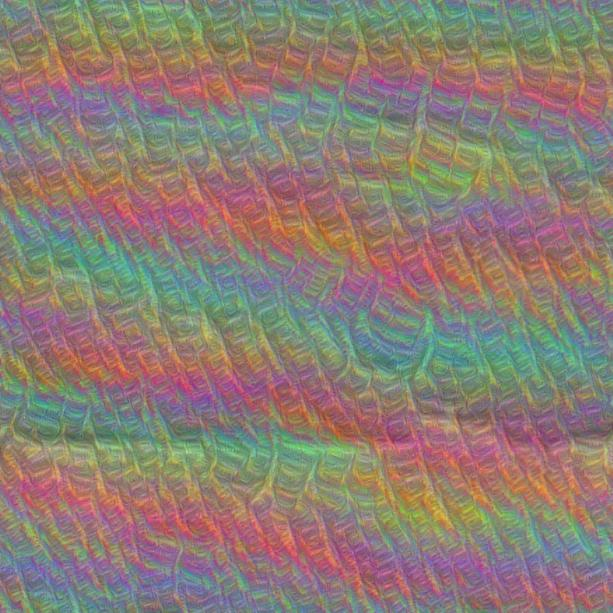

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

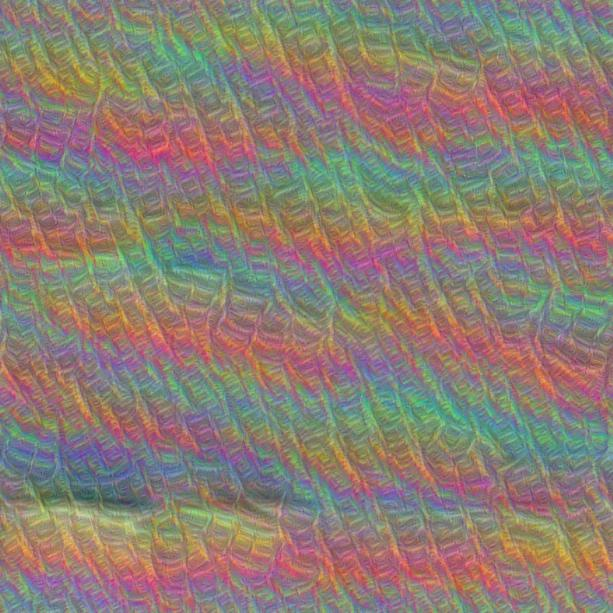

. 

KeyboardInterrupt: 

In [106]:
for i in range(frames+1):
    # control stable noise (or not) with seed
    np.random.seed(0)
    norm_noise = np.random.normal(loc =0.0, scale =0.25, size=(224,224,3))
    wght1 = i/frames
    wght2 = (frames-i)/frames
    render_lapnorm2_w(T('mixed4e_5x5_pre_relu')[:,:,:,50], t_obj2=feat_layer2, img0=norm_noise, score='sum', op='add', vis='fin', wght1=wght1, wght2=wght2, octave_n=4)

In [18]:
# setup read/write TO-DO: SETuUP DIFFERENT DIRECTORIES FOR EACH GIF

file_dir = os.getcwd()+"/feat_interp"
os.makedirs(file_dir, exist_ok=True)

In [123]:
frames = 100

for i in range(frames+1):
    # control stable noise (or not) with seed
    np.random.seed(0)
    norm_noise = np.random.normal(loc =0.0, scale =0.25, size=(224,224,3))
    wght1 = i/frames
    print(wght1)
    wght2 = (frames-i)/frames
    render_lapnorm2_w(T('mixed4e_5x5_pre_relu')[:,:,:,50], t_obj2=feat_layer2, img0=norm_noise, score='sum', op='add', vis='save', wght1=wght1, wght2=wght2, octave_n=4, file_dir=file_dir)

0.0
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 0.01
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 0.02
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 0.03
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 0.04
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 0.05
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 0.06
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 0.07
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 0.08
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 0.09
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 0.1
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 0.11
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [195]:
# Make our GIF

images = []
for file_name in os.listdir(file_dir):
    if file_name.endswith('.png'):
        file_path = os.path.join(file_dir, file_name)
        images.append(io.imread(file_path))
        print(np.asarray(images).shape)
io.mimsave(file_dir+'/interp100.gif', images, subrectangles=True)

ipyd.Image(url='interp100.gif',
           height=500, width=500)

(1, 613, 613, 3)
(2, 613, 613, 3)
(3, 613, 613, 3)
(4, 613, 613, 3)
(5, 613, 613, 3)
(6, 613, 613, 3)
(7, 613, 613, 3)
(8, 613, 613, 3)
(9, 613, 613, 3)
(10, 613, 613, 3)
(11, 613, 613, 3)
(12, 613, 613, 3)
(13, 613, 613, 3)
(14, 613, 613, 3)
(15, 613, 613, 3)
(16, 613, 613, 3)
(17, 613, 613, 3)
(18, 613, 613, 3)
(19, 613, 613, 3)
(20, 613, 613, 3)
(21, 613, 613, 3)
(22, 613, 613, 3)
(23, 613, 613, 3)
(24, 613, 613, 3)
(25, 613, 613, 3)
(26, 613, 613, 3)
(27, 613, 613, 3)
(28, 613, 613, 3)
(29, 613, 613, 3)
(30, 613, 613, 3)
(31, 613, 613, 3)
(32, 613, 613, 3)
(33, 613, 613, 3)
(34, 613, 613, 3)
(35, 613, 613, 3)
(36, 613, 613, 3)
(37, 613, 613, 3)
(38, 613, 613, 3)
(39, 613, 613, 3)
(40, 613, 613, 3)
(41, 613, 613, 3)
(42, 613, 613, 3)
(43, 613, 613, 3)
(44, 613, 613, 3)
(45, 613, 613, 3)
(46, 613, 613, 3)
(47, 613, 613, 3)
(48, 613, 613, 3)
(49, 613, 613, 3)
(50, 613, 613, 3)
(51, 613, 613, 3)
(52, 613, 613, 3)
(53, 613, 613, 3)
(54, 613, 613, 3)
(55, 613, 613, 3)
(56, 613, 613, 3)
(

KeyboardInterrupt: 

In [42]:
frames = 100

for i in range(frames+1):
    # control stable noise (or not) with seed
    np.random.seed(0)
    norm_noise = np.random.normal(loc =0.0, scale =0.25, size=(224,224,3))
    wght1 = i/frames
    print(wght1)
    wght2 = (frames-i)/frames
    render_lapnorm2_w(T('mixed4e_5x5_pre_relu')[:,:,:,50], t_obj2=feat_layer2, img0=norm_noise, score='sum', op='add', vis='zoomsave', wght1=wght1, wght2=wght2, octave_n=4, file_dir=file_dir)

0.0
. . . . . . . . . . (174, 174, 3)


/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(224, 224, 3)
. . . . . . . . . . (263, 263, 3)
(313, 313, 3)
. . . . . . . . . . (388, 388, 3)
(438, 438, 3)
. . . . . . . . . . (563, 563, 3)
(613, 613, 3)
0.01
. . . . . . . . . . (174, 174, 3)
(224, 224, 3)
. . . . . . . . . . (263, 263, 3)
(313, 313, 3)
. . . . . . . . . . (388, 388, 3)
(438, 438, 3)
. . . . . . . . . . (563, 563, 3)
(613, 613, 3)
0.02
. . . . . . . . . . (174, 174, 3)
(224, 224, 3)
. . . . . . . . . . (263, 263, 3)
(313, 313, 3)
. . . . . . . . . . (388, 388, 3)
(438, 438, 3)
. . . . . . . . . . (563, 563, 3)
(613, 613, 3)
0.03
. . . . . . . . . . (174, 174, 3)
(224, 224, 3)
. . . . . . . . . . (263, 263, 3)
(313, 313, 3)
. . . . . . . . . . (388, 388, 3)
(438, 438, 3)
. . . . . . . . . . (563, 563, 3)
(613, 613, 3)
0.04
. . . . . . . . . . (174, 174, 3)
(224, 224, 3)
. . . . . . . . . . (263, 263, 3)
(313, 313, 3)
. . . . . . . . . . (388, 388, 3)
(438, 438, 3)
. . . . . . . . . . (563, 563, 3)
(613, 613, 3)
0.05
. . . . . . . . . . (174, 174, 3)
(224, 224, 3)
.

. . . . . . . . . . (563, 563, 3)
(613, 613, 3)
0.42
. . . . . . . . . . (174, 174, 3)
(224, 224, 3)
. . . . . . . . . . (263, 263, 3)
(313, 313, 3)
. . . . . . . . . . (388, 388, 3)
(438, 438, 3)
. . . . . . . . . . (563, 563, 3)
(613, 613, 3)
0.43
. . . . . . . . . . (174, 174, 3)
(224, 224, 3)
. . . . . . . . . . (263, 263, 3)
(313, 313, 3)
. . . . . . . . . . (388, 388, 3)
(438, 438, 3)
. . . . . . . . . . (563, 563, 3)
(613, 613, 3)
0.44
. . . . . . . . . . (174, 174, 3)
(224, 224, 3)
. . . . . . . . . . (263, 263, 3)
(313, 313, 3)
. . . . . . . . . . (388, 388, 3)
(438, 438, 3)
. . . . . . . . . . (563, 563, 3)
(613, 613, 3)
0.45
. . . . . . . . . . (174, 174, 3)
(224, 224, 3)
. . . . . . . . . . (263, 263, 3)
(313, 313, 3)
. . . . . . . . . . (388, 388, 3)
(438, 438, 3)
. . . . . . . . . . (563, 563, 3)
(613, 613, 3)
0.46
. . . . . . . . . . (174, 174, 3)
(224, 224, 3)
. . . . . . . . . . (263, 263, 3)
(313, 313, 3)
. . . . . . . . . . (388, 388, 3)
(438, 438, 3)
. . . . . . . .

(313, 313, 3)
. . . . . . . . . . (388, 388, 3)
(438, 438, 3)
. . . . . . . . . . (563, 563, 3)
(613, 613, 3)
0.84
. . . . . . . . . . (174, 174, 3)
(224, 224, 3)
. . . . . . . . . . (263, 263, 3)
(313, 313, 3)
. . . . . . . . . . (388, 388, 3)
(438, 438, 3)
. . . . . . . . . . (563, 563, 3)
(613, 613, 3)
0.85
. . . . . . . . . . (174, 174, 3)
(224, 224, 3)
. . . . . . . . . . (263, 263, 3)
(313, 313, 3)
. . . . . . . . . . (388, 388, 3)
(438, 438, 3)
. . . . . . . . . . (563, 563, 3)
(613, 613, 3)
0.86
. . . . . . . . . . (174, 174, 3)
(224, 224, 3)
. . . . . . . . . . (263, 263, 3)
(313, 313, 3)
. . . . . . . . . . (388, 388, 3)
(438, 438, 3)
. . . . . . . . . . (563, 563, 3)
(613, 613, 3)
0.87
. . . . . . . . . . (174, 174, 3)
(224, 224, 3)
. . . . . . . . . . (263, 263, 3)
(313, 313, 3)
. . . . . . . . . . (388, 388, 3)
(438, 438, 3)
. . . . . . . . . . (563, 563, 3)
(613, 613, 3)
0.88
. . . . . . . . . . (174, 174, 3)
(224, 224, 3)
. . . . . . . . . . (263, 263, 3)
(313, 313, 3)
.

In [43]:
# Make our GIF

images = []
for file_name in os.listdir(file_dir):
    if file_name.endswith('.png'):
        file_path = os.path.join(file_dir, file_name)
        images.append(io.imread(file_path))
        print(np.asarray(images).shape)
io.mimsave(file_dir+'/zinterp100.gif', images, subrectangles=True)

ipyd.Image(url='zinterp100.gif',
           height=500, width=500)

(1, 613, 613, 3)
(2, 613, 613, 3)
(3, 613, 613, 3)
(4, 613, 613, 3)
(5, 613, 613, 3)
(6, 613, 613, 3)
(7, 613, 613, 3)
(8, 613, 613, 3)
(9, 613, 613, 3)
(10, 613, 613, 3)
(11, 613, 613, 3)
(12, 613, 613, 3)
(13, 613, 613, 3)
(14, 613, 613, 3)
(15, 613, 613, 3)
(16, 613, 613, 3)
(17, 613, 613, 3)
(18, 613, 613, 3)
(19, 613, 613, 3)
(20, 613, 613, 3)
(21, 613, 613, 3)
(22, 613, 613, 3)
(23, 613, 613, 3)
(24, 613, 613, 3)
(25, 613, 613, 3)
(26, 613, 613, 3)
(27, 613, 613, 3)
(28, 613, 613, 3)
(29, 613, 613, 3)
(30, 613, 613, 3)
(31, 613, 613, 3)
(32, 613, 613, 3)
(33, 613, 613, 3)
(34, 613, 613, 3)
(35, 613, 613, 3)
(36, 613, 613, 3)
(37, 613, 613, 3)
(38, 613, 613, 3)
(39, 613, 613, 3)
(40, 613, 613, 3)
(41, 613, 613, 3)
(42, 613, 613, 3)
(43, 613, 613, 3)
(44, 613, 613, 3)
(45, 613, 613, 3)
(46, 613, 613, 3)
(47, 613, 613, 3)
(48, 613, 613, 3)
(49, 613, 613, 3)
(50, 613, 613, 3)
(51, 613, 613, 3)
(52, 613, 613, 3)
(53, 613, 613, 3)
(54, 613, 613, 3)
(55, 613, 613, 3)
(56, 613, 613, 3)
(

NameError: name 'ipyd' is not defined

In [112]:
io.help('gif')

GIF-PIL - Static and animated gif (Pillow)

    A format for reading and writing static and animated GIF, based
    on Pillow.
    
    Images read with this format are always RGBA. Currently,
    the alpha channel is ignored when saving RGB images with this
    format.
    
    Parameters for reading
    ----------------------
    None
    
    Parameters for saving
    ---------------------
    loop : int
        The number of iterations. Default 0 (meaning loop indefinitely).
    duration : {float, list}
        The duration (in seconds) of each frame. Either specify one value
        that is used for all frames, or one value for each frame.
        Note that in the GIF format the duration/delay is expressed in
        hundredths of a second, which limits the precision of the duration.
    fps : float
        The number of frames per second. If duration is not given, the
        duration for each frame is set to 1/fps. Default 10.
    palettesize : int
        The number of colors t

Or an actual image

In [ ]:
# Interesting that polkadot images seem to "grow" humans ('mixed4e_5x5_pre_relu')
# TO-DO make our own 'polkadot' images instead of lossy compressed images
# TO-DO "dupe" the network into drawing humans, but do not include the polkadot image in the representation
img0 = np.asarray(PIL.Image.open('polkadots2.jpg'))[..., :3].astype(np.float32)
img0 = preprocess(img0)
render_lap2_mean_grad(T('mixed4e_5x5_pre_relu')[:,:,:,50],img0=img0, t_score2=feat_layer_comb, op='add', wght1=0.8, wght2=0.2, octave_n=4)

Now see if you can create a track from lower layers to higher layers and detect how features transform throughout. When are things recognizable? What do you think the textures' purposes are? Etc.

We can also begin to create a taxonomy of sorts by describing the features found in each layer and channel we explore. Let's start an open document to add to. Explore yourself and/or by these labeled (but undescribed) images from each [layer/channel](http://storage.googleapis.com/deepdream/visualz/tensorflow_inception/index.html).

Another idea is to create a gif that contains the shifting of weights from 2 feature spaces, say from 0. and 1. of feature space A and B to 1. and 0. 